In [1]:
# deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
# expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
# stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

# result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
# result['log2(18mo/2mo)'] = np.log2(result['fc'])
# result['-log10(padj)'] = -np.log10(result['fdr'])
# result.head()

# sig_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.5)]
# non_sig_result = result[(result['fdr'] >0.8) & (abs(result['log2(18mo/2mo)']) < 0.04)].sample(sig_result.shape[0])
# sig_result.shape, non_sig_result.shape

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from amb import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ALLCools.plot import *
age_palette = get_age_palette()

In [2]:
ct = 'L6bCT_ENT_Glut'

In [3]:
young_abc_df = pd.read_csv(f'{ct}.8wk.abc_score.csv', index_col = 0)
old_abc_df = pd.read_csv(f'{ct}.18mo.abc_score.csv', index_col = 0)

In [4]:
young_abc_df = young_abc_df[young_abc_df['1'] > 10]
old_abc_df = old_abc_df[old_abc_df['1'] > 10]

In [5]:
young_abc_df['gene_id'] = young_abc_df.index.map(lambda x: x.split('-')[-1])
old_abc_df['gene_id'] = old_abc_df.index.map(lambda x: x.split('-')[-1])

In [6]:
gene_meta = pd.read_csv('use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}

In [30]:
gene_meta['length'] = gene_meta['end'] - gene_meta['start']

In [34]:
long_genes = gene_meta[gene_meta['length'] >= 100000].index

In [36]:
old_abc_df = old_abc_df[old_abc_df['gene_id'].isin(long_genes)]
young_abc_df = young_abc_df[young_abc_df['gene_id'].isin(long_genes)]

In [37]:
def genome_pos(x):
    _chr, e_start, e_end, gene_id = x.split('-')
    e_start, e_end = int(e_start), int(e_end)
    #gene_start = int(gene_meta.loc[gene_id]['start'])
    #distance = abs(e_start - gene_start)
    return e_start

def pre_use_abs_df(df, cutoff):
    #use_df = df[df['gene_id'].isin([gene_name_to_id[gene] for gene in gene_list])]
    use_df =df
    use_df['gene_start'] = use_df['gene_id'].map(gene_meta['start'].to_dict())
    use_df['e_start'] = use_df.index.map(lambda x: genome_pos(x))
    use_df['eg_dist'] = abs(use_df['e_start'] - use_df['gene_start'])
    use_df = use_df[use_df['1'] >= cutoff]
    return use_df 
    
def set_cat(x, cutoff):
    if x < -cutoff:
        cat = 'young_active'
    elif x > cutoff:
        cat = 'old_active'
    else:
        cat = 'both_active'
    return cat
    

In [38]:
use_young_abc_df = pre_use_abs_df(young_abc_df, 5)
use_old_abc_df = pre_use_abs_df(old_abc_df, 5)

shared_e_g_pairs = list(set(use_young_abc_df.index) & set(use_old_abc_df.index))
shared_df=pd.concat([use_young_abc_df.loc[shared_e_g_pairs], use_old_abc_df.loc[shared_e_g_pairs][['0','1','2']]], axis = 1)
shared_df.columns = ['8wk.activity', '8wk.contacts','8wk.abc',
                     'gene_id','gene_start','e_start','eg_dist',
                     '18mo.activity', '18mo.contacts','18mo.abc',]

In [39]:
young_num = young_abc_df.shape[0]
old_num = old_abc_df.shape[0]
shared_e_g_pairs_num = shared_df.shape[0]

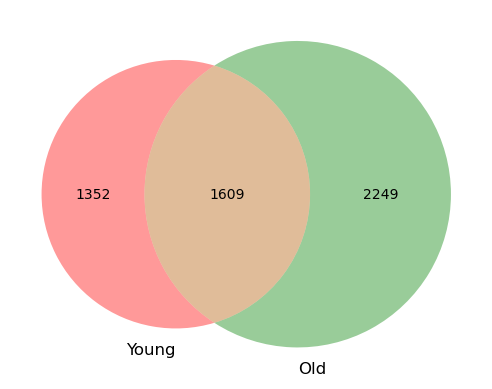

In [40]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

venn2(subsets = (young_num-shared_e_g_pairs_num, old_num-shared_e_g_pairs_num, shared_e_g_pairs_num), set_labels = ('Young', 'Old'))
plt.show()

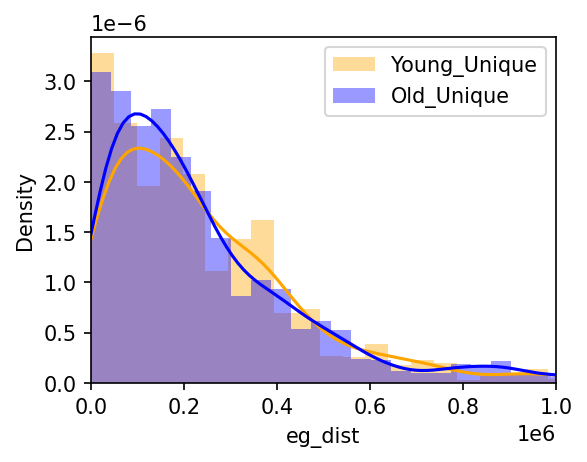

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.distplot(young_abc_df.loc[~young_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'],
             color='orange', ax=ax, label = 'Young_Unique')
sns.distplot(old_abc_df.loc[~old_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'], 
             color='blue', ax=ax, label = 'Old_Unique')

mean_young = young_abc_df.loc[~young_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
mean_old = old_abc_df.loc[~old_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
ax.set_xlim(0, 1e6)
ax.legend()


In [42]:
mean_young, mean_old

(263666.2596153846, 244771.25122276568)

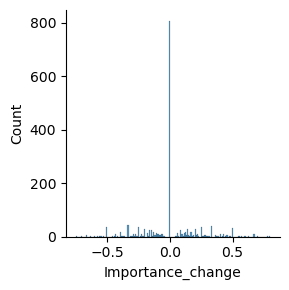

In [43]:
all_to_plot = []
for gene_id , tmpdf in shared_df.groupby('gene_id'):
    tmpdf['Rank_8wk'] = tmpdf['8wk.abc'].rank()
    tmpdf['Rank_18mo'] = tmpdf['18mo.abc'].rank()
    tmpdf['Importance_8wk'] = tmpdf['Rank_8wk']/tmpdf.shape[0]
    tmpdf['Importance_18mo'] = tmpdf['Rank_18mo']/tmpdf.shape[0]
    tmpdf['Importance_change'] = tmpdf['Importance_18mo'] - tmpdf['Importance_8wk'] 
    all_to_plot.append(tmpdf)
all_to_plot = pd.concat(all_to_plot)
sns.displot(all_to_plot['Importance_change'], height=3)

In [44]:
def set_cat(x):
    if x < -0.3 or x > 0.3:
        cat = 'Age Dynamic'
    else:
        cat = 'Non Age Dynamic'
    return cat
all_to_plot['cat'] = all_to_plot['Importance_change'].apply(lambda x: set_cat(x))

In [45]:
all_to_plot['contact_change'] = all_to_plot['18mo.contacts'] - all_to_plot['8wk.contacts']
all_to_plot['activity_change'] = all_to_plot['18mo.activity'] - all_to_plot['8wk.activity']

Text(0.5, 1.0, 'Activity Change (Young-Old)')

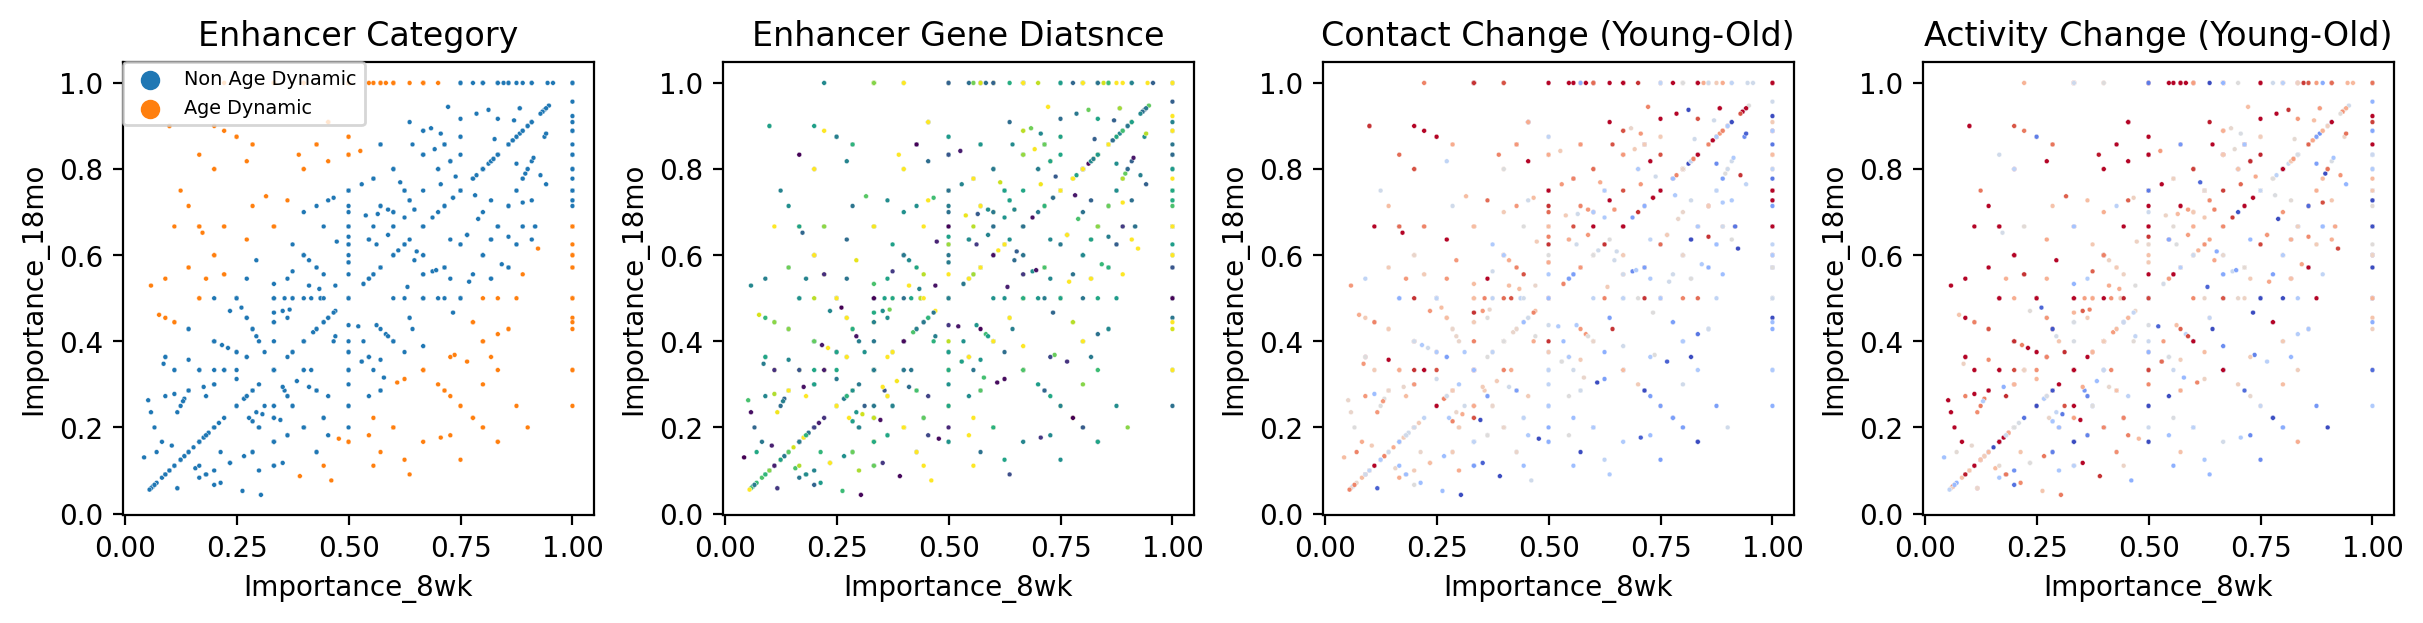

In [46]:
x = 'Importance_8wk'
y = 'Importance_18mo'

fig, axes = plt.subplots(figsize = (12,3), ncols = 4, dpi = 200, constrained_layout = True)

ax= axes[0]
sns.scatterplot(data = all_to_plot,
                hue = 'cat',
                ax = ax,s =3,
                x = x,
                y = y)
ax.legend(loc='upper left', borderaxespad=0,fontsize='x-small') #bbox_to_anchor=(1.05, 1), 
ax.set_title("Enhancer Category")


ax= axes[1]
sns.scatterplot(data = all_to_plot,
                hue = 'eg_dist',
                palette ='viridis',
                hue_norm = (0,4e5),
                legend = False,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Enhancer Gene Diatsnce")

ax= axes[2]
sns.scatterplot(data = all_to_plot,
                hue = 'contact_change',
                palette ='coolwarm',
                hue_norm = (-10,10),
                legend = False,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Contact Change (Young-Old)")

ax= axes[3]
sns.scatterplot(data = all_to_plot,
                hue = 'activity_change',
                palette ='coolwarm',
                hue_norm = (-0.1,0.1),
                legend = False,
                ax = ax,s =3,
                x = x,
                y = y)
ax.set_title("Activity Change (Young-Old)")

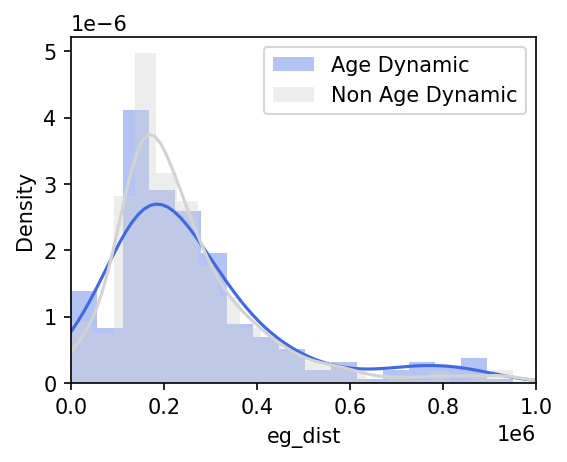

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.distplot(all_to_plot[all_to_plot['cat'] == 'Age Dynamic']['eg_dist'],
             color='royalblue', ax=ax, label = 'Age Dynamic')
sns.distplot(all_to_plot[all_to_plot['cat'] == 'Non Age Dynamic']['eg_dist'], 
             color='lightgrey', ax=ax, label = 'Non Age Dynamic')
ax.set_xlim(0, 1e6)
ax.legend()
